# 1. Aprendizaje no Supervisado

#### Gutierrez Coronado Matias Ezequiel
#### Ingeniería de Sistemas
#### CU: 35-5558

## DBSCAN

Usé DBSCAN porque en el dataset de autos ford.csv hay vehículos de muchos tipos y precios, así que los grupos pueden tener diferentes tamaños y formas, y además pueden existir autos raros o muy distintos al resto. DBSCAN es ideal para este tipo de datos porque no obliga a definir cuántos grupos habrá y puede identificar tanto los grupos comunes como los autos que no encajan en ninguno, algo que KMeans no hace tan bien, ya que siempre agrupa todo y espera que los grupos sean parecidos y redondeados.

## Preprocesamiento de los datos

En este paso cargo los datos del archivo ford.csv y selecciono las variables más importantes para el análisis. Después, normalizo los valores de cada columna para que todas las características estén en la misma escala y, finalmente, aplico PCA para reducir la información a dos dimensiones. Esto me ayuda a visualizar y analizar los grupos de autos de manera más sencilla.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

csv_path = '/content/drive/My Drive/Segundo Parcial/ford.csv'
df = pd.read_csv(csv_path)
features = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
X_raw = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

pca = PCA(n_components=2)
X = pca.fit_transform(X_scaled)



## Agrupamiento con DBSCAN

En este paso aplico el algoritmo DBSCAN a los datos ya procesados para identificar grupos de autos similares y también para señalar aquellos autos que no encajan con ninguno de los grupos principales.

In [29]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.10, min_samples=5)
dbscan.fit(X)


DBSCAN(eps=0.1)

## Etiquetas de los grupos detectados


In [30]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2])

## Agrupamiento con eps mayor

En este paso vuelvo a aplicar DBSCAN, pero ahora aumento el valor de eps para ver cómo cambia la cantidad y el tamaño de los grupos que se forman en los datos.

In [31]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)
np.unique(dbscan2.labels_)

array([0, 1])

## Visualización de los grupos encontrados

Grafico los resultados del agrupamiento para ver claramente cómo se forman los grupos y qué puntos no pertenecen a ninguno.

In [32]:
import matplotlib.pyplot as plt
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

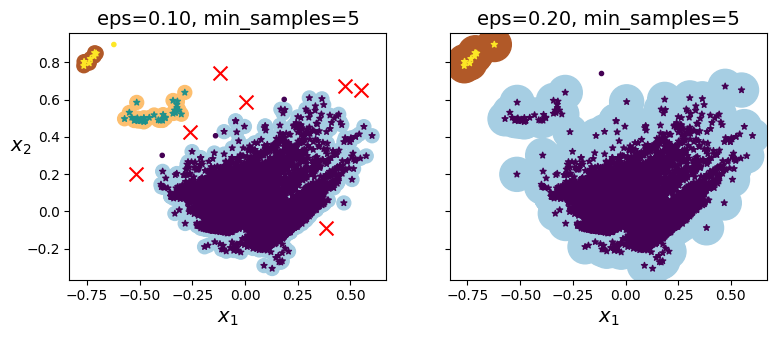

In [33]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

En estas dos gráficas muestro cómo cambia la agrupación de los autos al modificar el valor de eps en DBSCAN.
Con un eps más pequeño (izquierda), se forman varios grupos pequeños y se detectan más autos que no encajan en ningún grupo (señalados con una X roja). Al aumentar el eps (derecha), los grupos se hacen más grandes y la mayoría de los autos quedan agrupados, reduciendo la cantidad de autos fuera de grupo.
Esto muestra cómo el valor de eps afecta la cantidad y el tamaño de los grupos detectados.

Clasificación de nuevas zonas con KNN

Uso el algoritmo KNN para definir claramente las fronteras entre los grupos formados y poder clasificar cualquier nuevo auto según los clusters detectados por DBSCAN.

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])


KNeighborsClassifier(n_neighbors=10)

## Clasificación de autos nuevos según los grupos

Con estos ejemplos, pruebo cómo el modelo clasificaría distintos autos nuevos, usando las mismas transformaciones y el clasificador entrenado. Así puedo saber a qué grupo pertenecería cada uno según sus características.

In [35]:
X_01 = np.array([
    [2014, 32000, 8000, 250, 62.0, 4.5],
    [2018, 14500, 45000, 120, 50.0, 1.6],
    [2022, 32000, 8000, 250, 72.0, 8.5],
    [2016, 8000, 70000, 100, 48.0, 1.2],
])

X_02 = scaler.transform(X_01)
X_new = pca.transform(X_02)
knn.predict(X_new)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([1, 0, 2, 0])

## Probabilidad de pertenencia a cada grupo

In [36]:
knn.predict_proba(X_new)

array([[0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.3, 0.7],
       [1. , 0. , 0. ]])

## Visualización de las fronteras entre grupos

Con esta función grafico los datos y muestro claramente cómo quedan separadas las diferentes zonas o grupos que encontró el modelo.

In [37]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=10, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=10,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

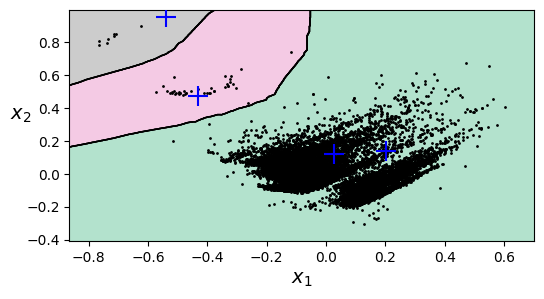

In [38]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

En este gráfico se muestran las distintas zonas o grupos de autos que detectó el modelo en el dataset. Cada color representa un grupo diferente, y los signos “+” azules marcan la posición de autos nuevos clasificados por el modelo.
El uso de KNN permite trazar de manera precisa las fronteras entre estos grupos y facilita que cualquier auto nuevo pueda ser asignado a una zona específica, dependiendo de sus características. Así, se puede ver claramente cómo el modelo separa distintos tipos de autos en el mercado y cómo clasificaría a los nuevos ejemplos dentro de esos grupos.